In [1]:
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [107]:
def createModelMatrix(matrixDim,sparsity):
    #matrixDim=10
    #sparsity = 0.01
    Amat = np.zeros((matrixDim,matrixDim))
    for i in range(0,matrixDim):
        Amat[i,i] = i + 1
    Amat = Amat + sparsity*np.random.randint(20,size=(matrixDim,matrixDim))
    Amat = (Amat.T + Amat)/2 
    print("Amat: \n",Amat)
    u,v=LA.eig(Amat)
    print('Correct roots: ',np.sort(u))
    return Amat

def defineAllVariables(Amat,matrixDim): #defines single vector p,q,eps,H0,V from a given matrix and its dimension
    p=np.zeros((matrixDim,1))
    q=np.zeros((matrixDim,matrixDim-1))
    print(np.shape(p),np.shape(q))
    diagMat=np.diag(Amat)
    print('diagonal of Matrix: ',diagMat)
    
    newDiag=[]
    for i in range(matrixDim):
        for j in range(matrixDim):
            if i==j:
                newDiag.append(Amat[i,j])
                
    print('new diagonal of matrix: ',newDiag)
    
    lowestElements=np.argsort(diagMat)
    print('lowest element index:',lowestElements)
    print('actual lowest element of Hbar:',diagMat[lowestElements[0]])

    p[lowestElements[0],0]=1.0
    print('p',p)
    counter=0
    for i in range(len(lowestElements)):
        if i==lowestElements[0]:
            continue
        else:
            q[lowestElements[i],counter]=1.0
            counter=counter+1


        
        
    H0=np.diag(np.diag(Amat))#np.matmul(np.matmul(projP,Amat),projP)
    V=Amat-H0
    print('V \n',V)
    #print('original Guess:',diagMat[0])
    guessEps=diagMat[lowestElements[0]] #+0.01
    eps=guessEps
    print('init Guess:',eps)
    
    return p,q,H0,V,eps




        
    
    
    
    

    
    
def defineAllVariables(Amat,matrixDim,blockSize): #defines single vector p,q,eps,H0,V from a given matrix and its dimension
    p=np.zeros((matrixDim,blockSize))
    q=np.zeros((matrixDim,matrixDim-blockSize))
    print(np.shape(p),np.shape(q))
    diagMat=np.diag(Amat)
    print('diagonal of Matrix: ',diagMat)
    
    newDiag=[]
    for i in range(matrixDim):
        for j in range(matrixDim):
            if i==j:
                newDiag.append(Amat[i,j])
                
    print('new diagonal of matrix: ',newDiag)
    
    lowestElements=np.argsort(diagMat)
    print('lowest element index:',lowestElements)
    print('actual lowest element of Hbar:',diagMat[lowestElements[0]])

    negateQ=[]
    eps=[]
    for x in range(blockSize):
        negateQ.append(lowestElements[x])
        p[lowestElements[x],x]=1.0
        eps.append(diagMat[lowestElements[x]])
        
    print('p',p)
    counter=0
    for i in range(len(lowestElements)):
        if i in negateQ:
            continue
        else:
            q[lowestElements[i],counter]=1.0
            counter=counter+1

    print('q:',q)
        
        
    H0=np.diag(np.diag(Amat))#np.matmul(np.matmul(projP,Amat),projP)
    V=Amat-H0
    print('V \n',V)
    #print('original Guess:',diagMat[0])
    #guessEps=diagMat[lowestElements[0]] #+0.01
    #eps=guessEps
    print('init Guess:',eps)
    
    return p,q,H0,V,eps
        
    
    
    
    

    
    



def extendPSpace(T0,V,p,order):
    T0V=np.matmul(T0,V)
    tmp=T0V
    
    for i in range(1,order+1):
        print('extending guess for order: ',i)
        tmp=np.matmul(tmp,T0V)
    
    print('relevant p to correct: ',p)
    correctionVec=np.matmul(tmp,p)
    print('Correction vector: \n',correctionVec)
    return correctionVec



def createT0_projQ(q,qDim,H0Dim,eps,H0): #qDim>0
    #print('q',q,eps,qDim)
    epsMat=np.zeros((H0Dim,H0Dim))
    denom=np.zeros((H0Dim,H0Dim))
    np.fill_diagonal(epsMat,eps)
    
    sumMatrix=np.zeros((H0Dim,H0Dim))
    for i in range(qDim):
        Q=np.outer(q[:,i],q[:,i])
        #print('Q outer:',Q)
        QH0Q=np.matmul(np.matmul(Q,H0),Q)
        denom=epsMat-QH0Q
        for x in range(H0Dim):
            if (abs(denom[x,x]) < 0.0001):
                if (denom[x,x]< 0.00000000000000001):
                    factor=-1.0
                    denom[x,x]=factor*0.0001
                else:
                    factor=1.0
                    denom[x,x]=factor*0.0001
            denom[x,x]=1.0/denom[x,x]
                
        #denom=inv(denom)
        sumMatrix=sumMatrix+np.matmul(np.matmul(Q,denom),Q) #q[:,i],denom),q[:,i].T)
    #print('T0 value is: ',sumMatrix)
    return sumMatrix

def computeRHR(fullSpace,H,HDim,order,iterator):
    ## test orthogonalizing fullspace
    #qq,r=LA.qr(fullSpace[:,:order+1])
    qq=fullSpace[:,:iterator+1]
    RHR=(qq.T @ H) @ qq
    print('RHR: \n',RHR)
    roots,vecs=LA.eig(RHR)
    print('Roots from <R|H|R> via QR:',np.sort(roots))
    indx=roots.argsort()
    theta=roots[indx]
    vecs=vecs[:,indx]
    #print('C_i vecs: ',vecs)
    usableRoots=[ elem for elem in theta if elem > 0.15 ]
    usableIndx=[x for x in range(len(theta)) if theta[x] > 0.15]
    #print('C_i vecs: ',vecs[:,usableIndx])
    print('test of roots: ',usableRoots)
    return usableRoots,vecs[:,usableIndx]#usableRoots,transformedVecs[:,usableIndx]   

def runVariationalAlgo(H,Hdim,blockSize):
    p,q,H0,V,eps=defineAllVariables(H,Hdim,blockSize)
    print('H0:',H0)
    fullSpace=np.zeros((Hdim,Hdim))
    print('shape of FS and p',np.shape(fullSpace),np.shape(p))
    fullSpace[:,:blockSize]=p[:,:blockSize]
    print('FullSpace:',fullSpace[:,:blockSize])
    order=0
    qDim=Hdim-blockSize
    Hbkup=H
    print('initial guess H0: ',eps)
    finalEps=[]
    for i in range(9):
        print('*********************************')
        print('*********************************')
        print('***** Iteration: ',i)
        for x in range(blockSize):
            T0=createT0_projQ(q,qDim,Hdim,eps[x],H0)
            pertVec=extendPSpace(T0,V,p[:,x],order) # first order correction
            iterator=i*blockSize+x
            print(np.shape(pertVec))
            fullSpace[:,blockSize+iterator]=pertVec[:]
            ## try orthogonalizing fullSpace
            qq,r=LA.qr(fullSpace[:,:blockSize+iterator+1])
            fullSpace[:,:blockSize+iterator+1]=qq
            
        order=order+1
        
        print('iterator:',iterator)

        ##
        ritzRoots,ritzVecs=computeRHR(fullSpace,H,Hdim,order,blockSize+iterator)
        #print('ritzVecs:',ritzVecs)
        #indx=ritzRoots.argsort()
        #ritzRoots=ritzRoots[indx]
        #ritzVecs=ritzVec[:,indx]
        realVecs=fullSpace[:,:blockSize+iterator+1] @ ritzVecs[:,0]
        overlap=realVecs.T @ realVecs
        print('overlap <R|R>: ',overlap)
        tmpRoots=(realVecs.T @ H) @ realVecs
        tmpRoots=tmpRoots/overlap
        print('<R|H|R>/<R|R> :',tmpRoots)
        print('ritzRoots:',np.sort(ritzRoots))
        tmpeps=np.sort(ritzRoots)
        print('tmp eps:',tmpeps)
        finalEps.append(np.sort(ritzRoots)[:blockSize])
        eps=[]
        for y in range(blockSize):
            eps.append(tmpeps[y])
            
        
    return finalEps
       




In [108]:
Hdim=20
sparsity=0.01
H=createModelMatrix(Hdim,sparsity)
runVariationalAlgo(H,Hdim,3)


Amat: 
 [[1.190e+00 1.400e-01 1.000e-01 7.000e-02 7.500e-02 9.500e-02 1.050e-01
  1.100e-01 1.900e-01 1.050e-01 7.000e-02 1.250e-01 6.500e-02 1.200e-01
  1.150e-01 1.100e-01 9.000e-02 9.500e-02 1.450e-01 9.500e-02]
 [1.400e-01 2.130e+00 8.000e-02 6.500e-02 1.000e-01 5.500e-02 1.100e-01
  4.500e-02 1.000e-02 4.500e-02 1.150e-01 1.000e-01 1.050e-01 7.000e-02
  9.000e-02 1.050e-01 9.000e-02 5.000e-02 8.500e-02 1.250e-01]
 [1.000e-01 8.000e-02 3.040e+00 1.000e-01 1.150e-01 6.500e-02 9.000e-02
  1.350e-01 9.000e-02 8.500e-02 1.350e-01 8.000e-02 5.500e-02 6.500e-02
  1.450e-01 1.350e-01 1.300e-01 1.600e-01 1.550e-01 1.450e-01]
 [7.000e-02 6.500e-02 1.000e-01 4.000e+00 1.450e-01 1.400e-01 9.500e-02
  7.500e-02 1.500e-02 5.500e-02 1.000e-01 1.250e-01 1.000e-01 1.050e-01
  1.000e-01 1.050e-01 5.500e-02 1.300e-01 1.350e-01 7.000e-02]
 [7.500e-02 1.000e-01 1.150e-01 1.450e-01 5.040e+00 6.000e-02 1.750e-01
  8.500e-02 1.600e-01 1.500e-01 9.000e-02 6.000e-02 9.500e-02 3.500e-02
  6.000e-02 1.300e-0

IndexError: index 20 is out of bounds for axis 1 with size 20

In [56]:
#HeH+
cisHeH=np.loadtxt('cisHeH.txt')
print(cisHeH)
finalCisHeH=np.zeros((11,11)) #dimension of HeH+ CIS matrix; defines i and j index as well

counter=0
for i in range(11):
    for j in range(i,11):
        print('i,j:',i,j)
        finalCisHeH[i,j]=cisHeH[counter]
        finalCisHeH[j,i]=finalCisHeH[i,j]
        counter=counter+1
        
print('finalCISheH',finalCisHeH)
guessRoots,guessVecs=LA.eig(finalCisHeH)
print('HeH+ CIS roots:',np.sort(guessRoots))

runVariationalAlgo(finalCisHeH,11,2)

[ 8.28692379e-01  5.54853946e-02  9.41294716e-03  0.00000000e+00
  0.00000000e+00  1.00346189e-02  0.00000000e+00  0.00000000e+00
  1.02642480e-02  4.58917500e-03  4.92319800e-02  1.20240609e+00
 -4.05652551e-02  0.00000000e+00  0.00000000e+00 -3.36256815e-02
  0.00000000e+00  0.00000000e+00 -4.23616784e-02 -2.23130733e-02
  9.31659731e-04  1.63686245e+00  0.00000000e+00  0.00000000e+00
 -2.91054360e-03  0.00000000e+00  0.00000000e+00  7.95477687e-03
  1.80429220e-02  2.29463146e-03  1.78808803e+00  0.00000000e+00
  0.00000000e+00 -2.38849123e-03  3.78608309e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.78808803e+00  0.00000000e+00
 -3.78608309e-02 -2.38849123e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.12464069e+00  0.00000000e+00  0.00000000e+00
  3.86410672e-02  4.88817502e-02  8.70826803e-03  2.36104099e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.36104099e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.01429477e+00 -2.22908

[array([0.81965157, 1.20488326]),
 array([0.81965061, 1.20487996]),
 array([0.81964986, 1.20487995]),
 array([0.81964986, 1.20487995])]

In [ ]:
0.81964986 1.20487995

In [109]:
# Water CIS
# Water CIS
water=np.loadtxt('waterCIS.txt')
print(water)
finalwater=np.zeros((100,100)) #dimension of HeH+ CIS matrix; defines i and j index as well

counter=0
for i in range(100):
    for j in range(100):
        #print('i,j:',i,j)
        finalwater[i,j]=water[counter]
        counter=counter+1
        
print('water',finalwater)
guessRoots,guessVecs=LA.eig(finalwater)
print('water CIS roots:',np.sort(guessRoots))
eps=runVariationalAlgo(finalwater,100,2)
print('Convergence Info: ',eps)

[ 2.03589324e+01  0.00000000e+00  1.26535320e-01 ... -3.97087662e-03
  0.00000000e+00  4.29091660e+01]
water [[ 2.03589324e+01  0.00000000e+00  1.26535320e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.04157538e+01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.26535320e-01  0.00000000e+00  2.06988393e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.74422163e+00
   0.00000000e+00 -3.97087662e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   3.93693088e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.97087662e-03
   0.00000000e+00  4.29091660e+01]]
water CIS roots: [ 0.37098005  0.43294249  0.46643802  0.53947209  0.5917756   0.70385187
  0.86811614  0.91322348  0.95268039  0.95798485  1.04455771  1.10665125
  1.11080485  1.11102898  1.15256459  1.18658206  1.219577    1.23959655
  1.28745578  1.291

extending guess for order:  1
extending guess for order:  2
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.88895131e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.70111690e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.92942133e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.37507861e-03
  0.

extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.83134172e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.25064696e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.58463141e-03  0.00000000e+00  0.00000000

extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.62920017e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.35492374e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0

In [100]:
eps=runVariationalAlgo(finalwater,100,5)

0.37098005  0.43294249  0.46643802  0.53947209  0.5917756

(100, 5) (100, 95)
diagonal of Matrix:  [20.35893244 20.41575378 20.69883934 20.66956258 20.90821183 21.12407872
 21.0628278  21.37183491 21.47385069 21.65058758 21.58771817 21.96159791
 22.26137875 22.29370527 22.97725823 23.03582055 23.17112117 23.46651558
 23.69552146 61.57365749  1.2634843   1.30880792  1.74096833  1.73368474
  1.82002973  1.98587599  2.02527345  2.28943815  2.3115082   2.49825721
  2.59670104  2.76244864  3.25953063  3.2670128   4.06320973  4.12038458
  4.25352619  4.54914025  4.80110362 43.82763304  0.6035821   0.75904956
  1.11055647  1.10883419  1.25982685  1.41606301  1.49451106  1.65366241
  1.73088402  1.87758931  1.94549172  2.15962324  2.63956436  2.69187266
  3.43219452  3.55661831  3.64218778  3.97547021  4.24215455 43.25011092
  0.48584799  0.56247718  1.10523601  0.95406594  1.05834158  1.24142559
  1.29567658  1.55593993  1.57214037  1.79022068  1.83447211  2.04036727
  2.51854735  2.54798704  3.35789925  3.33831579  3.56593271  3.78925498
  4.0781526

extending guess for order:  1
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.78568078e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.60729276e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.71354617e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.01221507e-04
  0.00000000e+00  0.00000000e+00  

extending guess for order:  1
extending guess for order:  2
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [ 0.00000000e+00  4.50818421e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.59921580e-05
  0.00000000e+00 -4.31140469e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.28083301e-04  0.00000000e+00
  0.00000000e+00  3.02150820e-02  0.00000000e+00  0.00000000e+00
  7.14659014e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.14194952e-03
  0.00000000e+00  8.11580839e-03  0.00000000e+00  0.00000000e+00
  0.

iterator: 19
RHR: 
 [[ 3.87224110e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.03439475e-01  0.00000000e+00 -1.98262790e-20
   0.00000000e+00  0.00000000e+00  2.64773070e-02 -3.55856206e-23
  -7.71038799e-21 -1.06497591e-18 -1.02611664e-18 -4.73819783e-02
   4.89868187e-20  1.43387478e-18  8.85035167e-19 -1.52239311e-16
   1.42498493e-03  1.00912447e-20  3.60701951e-18 -3.12323533e-16
   9.25831969e-16]
 [ 0.00000000e+00  4.57377022e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.30723716e-01  0.00000000e+00
   0.00000000e+00 -1.76314476e-20  5.28831271e-24 -2.02220761e-02
   1.51051100e-27 -8.67436163e-20 -7.87995051e-20 -7.16373548e-19
  -2.95288393e-02  1.14298260e-20 -2.94753152e-19  1.10419797e-18
   2.91587710e-19  8.10428908e-03 -5.34788873e-20  3.14432843e-18
   5.01008317e-17]
 [ 0.00000000e+00  0.00000000e+00  4.85847991e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.17509643e-01
   0.00000000e+00 

extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.92360097e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.49939792e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.81291450e-05  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.05206343e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.05267928e-03  0.00000000

extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.70390624e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.45496025e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.35965549e-

extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [-1.71636084e-03  0.00000000e+00  1.07252055e-04  0.00000000e+00
  0.00000000e+00  1.08471742e-03  0.00000000e+00  1.59751660e-03
  0.00000000e+00  0.00000000e+00  2.38041835e-03  0.00000000e+00
 -1.09999083e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.81498656e-04 -1.96463371e-04  0.00000000e+00 -8.41327960e-04
  1.23821270e-01  0.00000000e+00  7.82454591e-03  0.00000000e+00
  0.00000000e+00 -6.42503171e-02  0.00000000e+00 

extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
relevant p to correct:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Correction vector: 
 [ 0.00000000e+00  3.65195702e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.92705973e-05
  0.00000000e+00 -3.52418223e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.31273586e-04  0.00000000e+00
  0.00000000e+00  2.28254481e-02  0.00000000e+00  0.00000000e+00
  4.66802145e-03  0

In [101]:
print(eps)0.37098005  0.43294249  0.46643802  0.53947209  0.5917756

[array([0.37131445, 0.43315177, 0.46874845, 0.53970485, 0.59190495]), array([0.37116687, 0.43294334, 0.46649207, 0.53948683, 0.59178578]), array([0.37116596, 0.43294285, 0.46643881, 0.53948442, 0.59178444]), array([0.37116596, 0.43294285, 0.4664381 , 0.53948441, 0.59178443]), array([0.37116596, 0.43294285, 0.46643803, 0.53948441, 0.59178443]), array([0.37116596, 0.43294285, 0.46643802, 0.53948441, 0.59178443]), array([0.37116596, 0.43294285, 0.46643802, 0.53948441, 0.59178443]), array([0.37116596, 0.43294285, 0.46643802, 0.53948441, 0.59178443]), array([0.37116596, 0.43294285, 0.46643802, 0.53948441, 0.59178443])]


In [61]:
#water dimer
# Water DIMER CIS
water=np.loadtxt('waterDimerCIS.txt')
print(water)
finalwater=np.zeros((400,400)) #dimension of HeH+ CIS matrix; defines i and j index as well

counter=0
for i in range(400):
    for j in range(400):
        #print('i,j:',i,j)
        finalwater[i,j]=water[counter]
        counter=counter+1
        
print('water',finalwater)
guessRoots,guessVecs=LA.eig(finalwater)
print('water CIS roots:',np.sort(guessRoots))
eps=runVariationalAlgo(finalwater,400,2)

[ 2.03858698e+01 -6.63775542e-02  9.76401134e-06 ...  9.10180564e-05
  2.87149342e-01  4.31080244e+01]
water [[ 2.03858698e+01 -6.63775542e-02  9.76401134e-06 ... -6.84039285e-08
  -5.72244688e-07 -2.45261532e-07]
 [-6.63775542e-02  2.06779774e+01 -4.79667950e-04 ... -2.68429097e-09
   1.13027623e-07  4.79820299e-08]
 [ 9.76401134e-06 -4.79667950e-04  2.04264826e+01 ... -5.67865932e-07
   1.04906298e-04  4.36448033e-05]
 ...
 [-6.84039285e-08 -2.68429097e-09 -5.67865932e-07 ...  3.94809781e+00
   4.82079274e-04  9.10180564e-05]
 [-5.72244688e-07  1.13027623e-07  1.04906298e-04 ...  4.82079274e-04
   4.35236037e+01  2.87149342e-01]
 [-2.45261532e-07  4.79820299e-08  4.36448033e-05 ...  9.10180564e-05
   2.87149342e-01  4.31080244e+01]]
water CIS roots: [ 0.38009787  0.38330207  0.44547256  0.46771961  0.47004531  0.4791968
  0.55140005  0.56589452  0.56931695  0.58332701  0.60121499  0.62180315
  0.62875922  0.6534024   0.68489906  0.69741963  0.6975091   0.72655379
  0.73034158  0.7828

T0 value is:  [[-0.05008706  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04936481  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04998538 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.2834898   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02320026
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02342612]]
Correction vector: 
 [ 1.04767655e-08 -1.96318796e-10  3.25652219e-06 -1.21282783e-08
 -3.14025045e-09  2.38514734e-06  1.07257539e-08 -1.07498108e-07
  1.77403374e-06  1.00580802e-08 -1.14669244e-08  5.81641031e-08
  0.00000000e+00  2.57753885e-09 -1.23227718e-08 -3.83668039e-09
  7.39226170e-10  6.66731916e-07 -2.32796391e-08 -6.15864170e-07
 -1.20280424e-08 -7.48878101e-07 -1.09324371e-08 -9.65261303e-09
  3.57083233e-08 -2.66561916e-06 -4.81510570e-09  9.95454012e-09
  6.85696570e-09  9.14988606e-08  1.49206834e-07  1.972218

T0 value is:  [[-0.0499958   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04927616  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04989449 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28059085  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02318066
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02340614]]
extending guess for order:  1
Correction vector: 
 [-1.57699353e-08 -3.07045845e-09 -1.76534156e-06  2.44119460e-10
  1.30542815e-08 -1.62469995e-06  5.29724078e-09  6.53210742e-08
 -1.15532014e-06  2.12590298e-08  2.42771288e-08 -3.17394178e-08
  0.00000000e+00  3.20440241e-10  1.05730846e-08 -7.75602733e-08
 -7.39827822e-09 -2.68381956e-07  5.80185222e-09  1.87247028e-07
  1.04597318e-08  1.63241683e-07  2.05204855e-09  5.21481542e-09
 -1.41224089e-08  4.74328206e-08 -2.31502214e-09  3.93530014e-09
  6.20855799e-09 -1.49088541

T0 value is:  [[-0.04998689  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926751  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988561 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28031035  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317874
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02340419]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [ 1.95274548e-08  1.81015036e-09  3.53283499e-06 -1.13220620e-08
 -3.46269807e-08  2.62930264e-06 -3.68679238e-09 -1.20354961e-07
  1.95129766e-06 -2.06397785e-08 -4.03210128e-08  8.63258241e-08
  0.00000000e+00  5.19511665e-09 -1.22656986e-08 -5.05700566e-08
  8.72938202e-09  8.06699091e-07 -2.36829153e-08 -7.62368579e-07
 -2.13208827e-08 -8.66976402e-07 -1.20777434e-08 -1.28907511e-08
  6.75884185e-08 -4.80770368e-06 -9.12538362e-09  8.90592317e-0

T0 value is:  [[-0.04998562  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926628  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988435 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28027054  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317847
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02340391]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [-2.92965232e-08 -4.67304778e-09 -1.80286372e-06  1.57150762e-09
  3.21654082e-08 -1.64290769e-06  1.47962918e-08  6.61005743e-08
 -1.17561036e-06  4.45479137e-08  4.49847499e-08 -3.99367239e-08
  0.00000000e+00  3.04036207e-10  1.67515592e-08 -8.83251398e-08
 -1.51043046e-08 -2.70747744e-07  5.46646247e-09  1.83325449e-07
  1.98528321e-08  1.35437265e-07  2.37124738e-09  8.43239119e-09
 -2.35090641e-08 -1.61675257e-07 

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926624  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026951  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [ 3.85939542e-08  5.16571079e-09  3.50165393e-06 -1.11805895e-08
 -5.98630170e-08  2.62397134e-06 -1.54578766e-08 -1.20143485e-07
  1.94071162e-06 -4.50246885e-08 -6.80418083e-08  9.83579938e-08
  0.00000000e+00  3.62058684e-09 -2.35730734e-08 -5.76509833e-08
  2.12324367e-08  8.07446644e-07 -2.55614047e-08 -7.65143904e-07
 -3.97603173e-08 -8.62129764e-07 -1.45449798e-08 -2.10430798e-08
  8

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [-4.93514802e-08 -7.15640046e-09 -1.76197733e-06  3.73448462e-09
  4.96819957e-08 -1.61081236e-06  2.21246786e-08  6.43727152e-08
 -1.15080541e-06  6.04813858e-08  6.82623814e-08 -4.81659773e-08
  0.00000000e+00  3.03060572e-09  3.16015260e-08 -8.66241478e-08
 -2.69630369e-08 -2.59651218e-07  9.46088258e-09  1.72458091e-07
  3.95818801e-08  1.19628321e-07  5.41

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [ 5.97135640e-08  8.76034829e-09  3.41916192e-06 -1.14859012e-08
 -8.38737617e-08  2.55943572e-06 -2.60915925e-08 -1.17853028e-07
  1.89234974e-06 -6.59765515e-08 -9.55900861e-08  1.08460003e-07
  0.00000000e+00  9.73341434e-10 -3.82535544e-08 -6.06135803e-08
  3.51014603e-08  7.92187305e-07 -2.88979910e-08 -7.52368228e-07
 -6.1786

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [-6.98108522e-08 -9.61807325e-09 -1.67359944e-06  6.17686006e-09
  6.44167942e-08 -1.54007322e-06  2.75569857e-08  6.12056477e-08
 -1.09891806e-06  7.13501049e-08  8.95998701e-08 -5.47662822e-08
  0.00000000e+00  6.46254458e-09  4.79621383e-08 -8.58632270e-08
 -3.89761013e-08 -2.41064462e-07  1.4737272

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 7.97343191e-08  1.21675452e-08  3.32486174e-06 -1.17938963e-08
 -1.05300912e-07  2.48370269e-06 -3.54527941e-08 -1.15094450e-07
  1.83684068e-06 -8.39967703e-08 -1.20727050e-07  1.17181755e-07
  0.00000000e+00 -1.83361760e-09 -5.28087220e-08 -6.19417102e-08
  4.82476756e

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [-8.87310031e-08 -1.18850327e-08 -1.57990845e-06  8.53679615e-09
  7.66007165e-08 -1.46476425e-06  3.17317110e-08  5.78321189e-08
 -1.04392236e-06  7.93387185e-08  1.08351704e-07 -6.01857128e-08
  0.00000000e+00  9.87038281e-09  6.35181849e-08

In [62]:
print(eps)

[array([0.38418977, 0.39315923]), array([0.38062343, 0.38451878]), array([0.38011671, 0.38348891]), array([0.38010358, 0.38338363]), array([0.38009826, 0.38330619]), array([0.38009823, 0.38330273]), array([0.38009822, 0.38330212]), array([0.38009822, 0.38330207]), array([0.38009822, 0.38330207]), array([0.38009822, 0.38330207])]


10
[0.38418977 0.39315923]
[0.38062343 0.38451878]
[0.38011671 0.38348891]
[0.38010358 0.38338363]
[0.38009826 0.38330619]
[0.38009823 0.38330273]
[0.38009822 0.38330212]
[0.38009822 0.38330207]
[0.38009822 0.38330207]
[0.38009822 0.38330207]


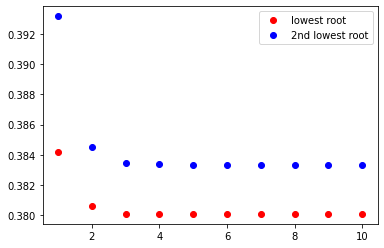

In [72]:
print(len(eps)) 
eps1=[]
eps2=[]
for x in eps:
    print(x)
    eps1.append(x[0])
    eps2.append(x[1])
 
xdata=np.arange(1,11)
plt.plot(xdata,eps1,'ro',label='lowest root')
plt.plot(xdata,eps2,'bo',label='2nd lowest root')
plt.legend()
plt.show()

In [ ]:
0.38009787  0.38330207

In [74]:
eps=runVariationalAlgo(finalwater,400,10)

(400, 10) (400, 390)
diagonal of Matrix:  [20.38586983 20.67797738 20.42648264 20.70071916 20.76340146 20.9923499
 21.20892226 21.23207859 21.21849069 20.96764027 21.14913086 21.46383157
 21.07620466 21.59381867 21.41696334 21.48156924 21.75990229 21.8351413
 21.72427651 22.00786791 21.79146121 21.99403018 22.2272083  22.24826368
 22.29912543 22.29760056 22.88136634 22.82721895 22.98074711 23.40627212
 23.38564839 23.78718566 23.19698571 23.92417498 23.48394108 24.24171745
 23.70333973 24.49988522 61.91338065 63.54904413 20.54312089 20.39248388
 20.67410234 20.48826794 21.07160016 20.97332825 20.75761528 20.96817411
 20.88292401 21.27093951 21.36242604 21.1404326  21.46871498 21.17710268
 21.70966165 21.75475853 21.46798802 21.49965863 21.96391676 21.67029917
 21.86123298 22.20156063 21.84111918 22.00574431 22.65253988 22.77037314
 22.29655449 22.53693723 23.62141869 23.29196105 23.34905197 23.05700675
 23.8308967  23.17561012 24.12735792 23.48179231 24.38614038 23.70347399
 63.3578083

T0 value is:  [[-0.05008706  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04936481  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04998538 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.2834898   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02320026
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02342612]]
Correction vector: 
 [ 1.04767655e-08 -1.96318796e-10  3.25652219e-06 -1.21282783e-08
 -3.14025045e-09  2.38514734e-06  1.07257539e-08 -1.07498108e-07
  1.77403374e-06  1.00580802e-08  0.00000000e+00  5.81641031e-08
  0.00000000e+00  2.57753885e-09 -1.23227718e-08 -3.83668039e-09
  7.39226170e-10  6.66731916e-07 -2.32796391e-08 -6.15864170e-07
 -1.20280424e-08 -7.48878101e-07 -1.09324371e-08 -9.65261303e-09
  3.57083233e-08 -2.66561916e-06 -4.81510570e-09  9.95454012e-09
  0.00000000e+00  9.14988606e-08  1.49206834e-07  1.972218

T0 value is:  [[-0.05029067  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04956258  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05018816 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29013817  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02324385
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02347056]]
Correction vector: 
 [-1.07008992e-08 -8.08383203e-09 -3.87310912e-06  3.80753901e-09
  5.28878255e-08 -3.18490139e-06  1.00983059e-08  1.41164606e-07
 -2.24589777e-06  2.85387470e-08  0.00000000e+00 -1.29899676e-07
  0.00000000e+00 -1.09400539e-08 -2.65301038e-09  1.72246658e-07
 -7.88518975e-09 -8.84223696e-07  2.39890436e-08  8.43847773e-07
  2.42541877e-08  6.92605549e-07  1.05566268e-08  1.50744704e-08
 -1.12940483e-07  9.84569120e-06  2.38642613e-08 -2.25196227e-08
  0.00000000e+00 -2.91334954e-07  4.03675534e-08 -2.860032

T0 value is:  [[-0.05034715  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04961743  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05024441 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29202822  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.0232559
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02348286]]
Correction vector: 
 [-4.91772291e-08  1.53031387e-07  3.97764263e-05  8.29636133e-08
 -1.80421066e-07  3.44266105e-05 -9.37819293e-08 -1.33021101e-06
  2.30713058e-05 -3.50040881e-07  0.00000000e+00  7.70313857e-07
  0.00000000e+00  9.74840791e-08  6.04397759e-08  1.58548556e-05
  5.65115595e-08  5.13682699e-06  9.44951567e-08 -9.79940151e-07
  8.12084482e-08 -2.23411296e-06  2.61180328e-08  4.84361955e-08
  4.85775545e-07 -3.86838485e-05 -1.18457151e-07  1.80994237e-07
  0.00000000e+00 -1.60843846e-04  1.71567274e-04  3.8654824

T0 value is:  [[-0.05038773  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04965685  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05028483 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29339899  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02326456
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349168]]
Correction vector: 
 [-6.58870108e-09  1.94555245e-09  6.88002390e-06 -2.69867916e-08
 -3.21115139e-08  5.11125425e-06  1.43770740e-08 -2.33018040e-07
  3.72497566e-06  8.51087583e-09  0.00000000e+00  1.38197991e-07
  0.00000000e+00  1.69424477e-08  1.74683083e-09  9.35483699e-08
 -5.43726557e-09  1.63571139e-06 -4.13079499e-08 -1.50452939e-06
 -8.50668015e-09 -1.73787434e-06 -2.10402218e-08 -9.47535204e-09
  7.81063010e-08 -7.84031186e-06 -2.01304127e-08  2.31416132e-08
  0.00000000e+00  1.46998886e-07  3.59457839e-07  6.696644

T0 value is:  [[-0.05050326  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04976905  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05039988 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29735965  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328916
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02351676]]
Correction vector: 
 [ 8.88785888e-05 -3.84139686e-05  3.75746787e-08 -4.66528077e-05
  4.64798987e-05  1.72016918e-07  4.49241678e-05 -7.08759055e-07
  1.62582183e-07  7.95933270e-05  0.00000000e+00  5.36497408e-06
  0.00000000e+00 -2.38388057e-05 -8.19102037e-05 -3.93094925e-07
  2.55137282e-05  2.02816536e-07 -4.75896307e-05  1.01635060e-06
 -7.26403322e-05  1.64771888e-07 -2.58235156e-05 -4.39236394e-05
  7.00747990e-05  9.17637301e-07  1.55160997e-05  4.07342305e-06
  0.00000000e+00 -1.12671862e-07  1.52905025e-07  4.162298

T0 value is:  [[-0.04998612  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926676  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988485 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28028635  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317858
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02340402]]
extending guess for order:  1
Correction vector: 
 [-1.57114940e-08 -3.01544852e-09 -1.66403875e-06  6.63555037e-11
  1.11148758e-08 -1.52076872e-06  4.89009020e-09  6.00482284e-08
 -1.07204615e-06  2.00833840e-08  0.00000000e+00 -2.93215020e-08
  0.00000000e+00  6.07259625e-10  1.06976585e-08 -8.12712045e-08
 -7.14489415e-09 -2.34695935e-07  4.89216730e-09  1.44618499e-07
  1.00945783e-08  1.51593699e-07  1.82939246e-09  4.98692289e-09
 -1.31122152e-08 -7.36119563e-08 -2.64931539e-09  4.28537981e-09
  0.00000000e+00 -1.35936288

T0 value is:  [[-0.05016417  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04943971  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05006218 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28597783  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321679
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02344298]]
extending guess for order:  1
Correction vector: 
 [ 1.69213190e-08  1.24016807e-08  4.76199969e-06  4.40523962e-08
 -4.21046154e-07  3.61949110e-06 -2.09188729e-07 -2.01161705e-07
  2.61664658e-06 -4.42930431e-07  0.00000000e+00  1.93576668e-07
  0.00000000e+00  3.39341364e-08  4.66971035e-08  2.47411353e-08
  7.69598689e-08  6.80801183e-07  8.07912167e-08 -5.48017200e-07
 -9.38551654e-09 -7.57685924e-07  1.21629400e-08  2.57673320e-08
  2.41850335e-08  1.26971188e-06  7.15145459e-09 -7.28754761e-08
  0.00000000e+00 -3.94154247

T0 value is:  [[-0.05021419  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.0494883   0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.050112   ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28761111  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.0232275
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345389]]
extending guess for order:  1
Correction vector: 
 [ 1.15778885e-07 -8.44772327e-08 -3.37197527e-06 -5.31881169e-08
  1.05275372e-07 -3.29346350e-06  7.66415799e-08  1.02143315e-07
 -2.13228959e-06  1.85446613e-07  0.00000000e+00 -7.24998942e-08
  0.00000000e+00 -3.51702554e-08 -1.53464517e-07  7.94663227e-06
  7.29763043e-08 -7.47251847e-07 -8.44459823e-10  2.13395778e-06
 -1.02342089e-07  2.31377097e-06 -3.61439886e-08 -6.09500275e-08
 -1.56065830e-08  9.16125805e-06  3.81044533e-08  9.48182086e-08
  0.00000000e+00 -8.79736932e

T0 value is:  [[-0.05043078  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04969866  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05032771 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29486465  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327373
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02350104]]
extending guess for order:  1
Correction vector: 
 [ 2.25434395e-08 -5.03854312e-08 -2.32295002e-05 -3.13416455e-09
  3.21131595e-08 -1.95989062e-05 -1.08511161e-08  7.83068894e-07
 -1.36900784e-05  8.95856233e-08  0.00000000e+00 -4.57945176e-07
  0.00000000e+00 -4.73954612e-08 -5.12344828e-08  7.85977481e-07
  3.87924429e-08 -4.24056789e-06  8.05144639e-08  3.50274250e-06
 -3.20876588e-08  1.03092966e-06 -8.00921445e-09 -4.99823164e-09
 -2.99861613e-07  2.58829219e-05  6.31529529e-08 -2.45988705e-08
  0.00000000e+00 -2.85313437

T0 value is:  [[-0.05047169  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04973839  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05036845 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29626879  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328244
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02350992]]
extending guess for order:  1
Correction vector: 
 [ 2.88792412e-05 -2.32402115e-04 -1.53479774e-06 -3.37343083e-04
 -1.00601806e-04 -6.29433818e-07  1.79128320e-04 -2.19501943e-04
 -1.26267607e-05  4.48804392e-04  0.00000000e+00  6.10402803e-05
  0.00000000e+00 -1.21945492e-05 -1.60539206e-04 -7.51984998e-07
  4.08161188e-05  7.62090119e-08 -5.87589600e-05  1.28901930e-06
 -1.55748565e-04  1.09249302e-06 -1.42380552e-04 -1.10688700e-04
 -5.17818550e-05  1.30297171e-06  2.08446451e-05  1.12402774e-04
  0.00000000e+00 -6.40675051

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926626  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28027     0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317847
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [ 1.93940887e-08  1.83352958e-09  3.48043547e-06 -1.11038722e-08
 -3.43025364e-08  2.59534309e-06 -3.71444043e-09 -1.18869102e-07
  1.92862767e-06 -2.04918609e-08  0.00000000e+00  8.52822579e-08
  0.00000000e+00  5.11107303e-09 -1.21150850e-08 -4.88012001e-08
  8.68305997e-09  7.99828129e-07 -2.34187017e-08 -7.57910117e-07
 -2.10547860e-08 -8.54601331e-07 -1.19028749e-08 -1.27350757e-08
  6.70920490e-08 -4.76294729e-06 -9.04133907e-09  8.73831071e-0

T0 value is:  [[-0.05015021  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942615  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004827 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28552469  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.0232138
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343993]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [ 9.28609722e-07 -1.53543121e-06 -2.68149262e-06 -4.53715967e-06
  2.34351268e-05 -2.33619347e-06  1.29967725e-05  2.44433799e-06
 -1.46867049e-06  2.57943910e-05  0.00000000e+00 -7.65682978e-06
  0.00000000e+00 -2.17523697e-06 -5.07776314e-06 -1.96056859e-07
 -3.83304722e-06 -3.58538316e-07 -6.17226019e-06  3.57826339e-07
 -9.71065935e-07  2.84728112e-07 -1.57297343e-06 -2.45941628e-06
  2.58378940e-08 -2.90753490e-06  2.56568684e-07  3.88915729e-06

T0 value is:  [[-0.05021135  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948554  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010916 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751781  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [-2.33087283e-07  1.05393124e-07 -2.97866512e-06  2.01783451e-07
 -1.13006214e-06 -1.00767465e-06 -6.21395676e-07 -5.45323565e-08
 -1.74955931e-06 -1.18311638e-06  0.00000000e+00  2.61576381e-07
  0.00000000e+00  1.52305593e-07  2.83791238e-07  2.28754998e-05
  2.39137921e-07 -2.58534797e-06  5.89153043e-07  6.12095138e-06
  1.91666311e-07 -2.66608113e-06  7.79612860e-08  2.09777596e-07
 -8.75659135e-08  9.21584131e-07 -6.08415191e-08  4.87568815e-0

T0 value is:  [[-0.05041999  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968818  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031695 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29449592  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327143
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349869]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [ 4.00949617e-08  7.69056118e-08  1.49793972e-05  1.13941305e-08
 -1.83935142e-07  1.15174142e-05 -6.51127136e-08 -4.73670254e-07
  8.07733064e-06 -1.83067991e-07  0.00000000e+00  2.62959891e-07
  0.00000000e+00  3.44776587e-08  1.26133326e-08  1.64951613e-07
  3.44015355e-08  2.93588938e-06 -4.59038646e-08 -2.54055298e-06
 -4.66275360e-08 -3.22294182e-06 -2.47146643e-08 -1.77965126e-08
  3.49361957e-08 -5.46385476e-06 -1.99621319e-08  1.38725908e-0

T0 value is:  [[-0.05046294  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972989  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035973 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328058
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02350802]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [-3.76412457e-03  2.29915918e-03 -2.89091440e-05  2.12066347e-03
 -2.71176440e-03 -3.04953846e-05 -2.29155281e-03  1.22241692e-04
 -1.85076431e-05 -4.08943348e-03  0.00000000e+00 -6.70654107e-05
  0.00000000e+00  1.17722129e-03  3.64478316e-03  1.57017525e-05
 -9.08426022e-04 -1.27561335e-05  2.17146891e-03 -4.48338777e-05
  2.83269603e-03 -7.16062771e-06  1.12632409e-03  1.80965627e-03
 -3.33963807e-03 -1.98729351e-05 -7.75003416e-04 -1.22405694e-0

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926626  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026988  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317847
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [-2.97105952e-08 -4.77193952e-09 -1.71468287e-06  1.10292208e-09
  3.13801543e-08 -1.54922220e-06  1.51185456e-08  6.12098505e-08
 -1.10039391e-06  4.49333749e-08  0.00000000e+00 -3.78030460e-08
  0.00000000e+00  6.22422201e-10  1.68825081e-08 -9.32709438e-08
 -1.52597387e-08 -2.38470925e-07  4.24821326e-09  1.41190561e-07
  1.96361099e-08  1.20745202e-07  2.04902776e-09  8.16352785e-09
 -2.22873572e-08 -3.41956974e-07 

T0 value is:  [[-0.05014954  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.0494255   0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004761 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550298  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [-3.19865212e-06 -2.51759580e-05 -1.26848022e-05 -8.34902069e-05
  5.45700468e-04 -8.49569603e-06  2.88152700e-04  6.05909321e-05
 -1.94038667e-06  5.72103915e-04  0.00000000e+00 -1.81635245e-04
  0.00000000e+00 -4.42711126e-05 -9.19086846e-05 -4.95954124e-07
 -9.98071119e-05 -2.40984319e-06 -1.30506978e-04  5.62489896e-06
  6.47014235e-06  2.81193185e-06 -2.63090158e-05 -3.98326619e-05
 -1.34771267e-05  4.69780190e-06 

T0 value is:  [[-0.05021134  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.2875175   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [ 7.60335970e-08  3.21957061e-09 -1.93751354e-06  2.13834142e-07
 -8.45827495e-07 -1.00077697e-06 -5.14008843e-07 -4.07749748e-08
 -8.82761062e-07 -9.98105665e-07  0.00000000e+00  2.52974912e-07
  0.00000000e+00  5.11978991e-08  4.66121823e-08  1.39179397e-05
  2.62274733e-07 -7.77793448e-07  3.05658747e-07  3.20565248e-06
 -2.53719013e-08  1.60654567e-06  4.91187087e-08  6.53573096e-08
  9.69568345e-08  7.68202867e-06 

T0 value is:  [[-0.05041781  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968606  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031478 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29442161  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327097
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349822]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [-2.14848453e-07 -2.99213938e-07 -4.85473409e-05 -1.52760308e-07
  2.84886798e-07 -4.20613973e-05  1.77944976e-07  1.55737889e-06
 -2.90041293e-05  6.25702454e-07  0.00000000e+00 -1.09235793e-06
  0.00000000e+00 -8.19317623e-08 -2.32987424e-08  6.91114341e-07
 -7.48469861e-08 -8.30952712e-06  1.51374203e-07  6.43538709e-06
  1.37159368e-07  3.02634457e-07 -4.59806355e-08  6.89541683e-08
 -8.25149294e-07  5.80997665e-05 

T0 value is:  [[-0.05046289  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972984  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035968 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596572  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328057
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02350801]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [-3.84453411e-03  2.47773861e-02  2.00913641e-04  3.57889889e-02
  3.05280350e-03  8.97474593e-05 -2.23341073e-02  2.19939622e-02
  1.27062932e-03 -5.42447464e-02  0.00000000e+00 -3.97090066e-03
  0.00000000e+00  2.44163099e-03  1.98710692e-02  9.33620384e-05
 -3.45667972e-03 -3.07009851e-06  8.56189038e-03 -2.01014873e-04
  1.72484613e-02 -1.14843680e-04  1.52615387e-02  1.28175778e-02
  2.96457701e-03 -2.08300748e-04 

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [ 3.87614555e-08  5.23102120e-09  3.49981127e-06 -1.10896631e-08
 -6.00369418e-08  2.62783847e-06 -1.54994284e-08 -1.20376484e-07
  1.94630905e-06 -4.50024799e-08  0.00000000e+00  9.84600900e-08
  0.00000000e+00  3.57621300e-09 -2.36166847e-08 -5.64098639e-08
  2.13252247e-08  8.11619471e-07 -2.56121950e-08 -7.71375209e-07
 -3.97830096e-08 -8.61936303e-07 -1.45556098e-08 -2.10719822e-08
  8

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550263  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [ 7.10639062e-05 -1.12819585e-04  6.71445843e-06 -3.33944363e-04
  1.72303306e-03  8.23824472e-06  9.55338966e-04  1.73096088e-04
  1.87449325e-05  1.89414813e-03  0.00000000e+00 -5.61206436e-04
  0.00000000e+00 -1.60404281e-04 -3.75478134e-04 -1.55724831e-06
 -2.80863062e-04  5.56091792e-07 -4.54423848e-04  1.18252599e-05
 -7.24803367e-05  1.75574435e-07 -1.15814335e-04 -1.81325910e-04
  2

T0 value is:  [[-0.05021134  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751746  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [-1.41158902e-08  1.21158760e-07 -1.65222140e-05 -1.73131251e-07
  2.06259451e-06 -1.16500270e-05  1.01618147e-06  7.88048579e-07
 -9.50463691e-06  2.23509763e-06  0.00000000e+00 -1.01452279e-06
  0.00000000e+00 -1.56916581e-07 -4.52823362e-07  3.35832971e-05
 -1.47728401e-07 -5.81045548e-06 -1.46398444e-07  1.06036323e-05
 -7.39680113e-08 -3.04868647e-06 -1.45733874e-07 -1.74241431e-07
 -3

T0 value is:  [[-0.05041739  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968566  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031437 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440742  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327088
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349813]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [ 4.37121670e-07  5.51194178e-07  7.30851451e-06  2.48062090e-07
 -1.16447845e-06  3.31012557e-06 -6.39122090e-07 -8.81652221e-08
  2.49226226e-06 -1.24664381e-06  0.00000000e+00  3.50299350e-07
  0.00000000e+00  6.20755472e-08 -8.71190811e-08  7.28947507e-07
  4.22108294e-07  2.07419423e-06  4.27543305e-08 -2.22950133e-06
 -5.34435396e-07 -7.28483021e-06 -5.86840650e-08 -1.85507572e-07
 -1

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596494  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [ 2.30349468e-01 -1.50848153e-01  1.65887867e-03 -1.46628431e-01
  1.63131950e-01  1.81225024e-03  1.50329028e-01 -1.82324440e-02
  5.03924051e-04  2.75809382e-01  0.00000000e+00  5.88007448e-03
  0.00000000e+00 -7.25957156e-02 -2.31472871e-01 -9.99794612e-04
  5.69866241e-02  7.77356094e-04 -1.36296266e-01  2.82521680e-03
 -1.81205146e-01  4.91965476e-04 -7.60472578e-02 -1.16636950e-01
  2

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [-4.99466701e-08 -7.33734012e-09 -1.67718092e-06  3.15247985e-09
  4.89691731e-08 -1.52023403e-06  2.25412277e-08  5.94907586e-08
 -1.07790057e-06  6.10443851e-08  0.00000000e+00 -4.61727906e-08
  0.00000000e+00  3.39369309e-09  3.17283272e-08 -9.17049601e-08
 -2.72035367e-08 -2.28152316e-07  8.18009371e-09  1.31130136e-07
  3.93921934e-08  1.05362573e-07  5.06

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.2855026   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [-4.33619845e-04 -3.40469143e-03  5.27969804e-05 -1.12975311e-02
  7.38262007e-02  1.30594659e-04  3.89878710e-02  8.14010799e-03
  6.82945353e-04  7.74023478e-02  0.00000000e+00 -2.45478085e-02
  0.00000000e+00 -5.98728271e-03 -1.24359155e-02 -7.24150708e-05
 -1.35047977e-02 -5.84569052e-06 -1.76649999e-02  4.71092098e-04
  8.75249197e-04  4.66013023e-06 -3.56

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [ 6.98776528e-07 -4.23466431e-07 -6.25085550e-06 -7.12440548e-07
  1.95637840e-06 -3.86646565e-06  1.33141148e-06  2.28676493e-07
 -3.19069540e-06  2.75572776e-06  0.00000000e+00 -6.75249217e-07
  0.00000000e+00 -3.43973062e-07 -1.09456856e-06  2.38399225e-05
  8.01149151e-08 -2.10863326e-06 -6.21240645e-07  6.07721067e-06
 -7.49116573e-07  1.51440412e-06 -3.78

T0 value is:  [[-0.05041737  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440653  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327088
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [-1.83584575e-06 -1.85374552e-06 -5.93954628e-05 -1.40485288e-06
  3.39033292e-06 -5.37466558e-05  2.33373408e-06  1.47531385e-06
 -3.71190146e-05  5.17873844e-06  0.00000000e+00 -2.71906318e-06
  0.00000000e+00 -1.82251045e-07  4.93494273e-08  7.16668009e-06
 -1.27952865e-06 -1.04018284e-05 -8.33502594e-08  8.88733855e-06
  1.53600359e-06 -3.60695821e-06 -2.76

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596492  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [ 1.14209973e-01 -1.41287652e+00 -1.28990554e-02 -2.07671282e+00
 -2.65043942e-01 -6.29678774e-03  1.26679963e+00 -1.31264644e+00
 -7.66098606e-02  3.12195147e+00  0.00000000e+00  2.35317420e-01
  0.00000000e+00 -1.09986047e-01 -1.07666632e+00 -5.10092957e-03
  1.78566578e-01 -2.07669942e-04 -4.45782254e-01  1.06561178e-02
 -9.44716661e-01  6.65497685e-03 -8.78

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [ 6.00231747e-08  8.88750937e-09  3.42057377e-06 -1.13122877e-08
 -8.40871764e-08  2.56621283e-06 -2.61867000e-08 -1.18119499e-07
  1.90018099e-06 -6.60492354e-08  0.00000000e+00  1.08683849e-07
  0.00000000e+00  8.96014878e-10 -3.83106738e-08 -5.96632526e-08
  3.52465590e-08  7.97252768e-07 -2.89397604e-08 -7.59663051e-07
 -6.1822

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.2855026   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [ 9.78473687e-03 -1.52971941e-02  3.45322953e-05 -4.52026311e-02
  2.32269243e-01  3.39563439e-04  1.28903062e-01  2.33195312e-02
  1.97711761e-03  2.55575087e-01  0.00000000e+00 -7.56243730e-02
  0.00000000e+00 -2.16751636e-02 -5.08317496e-02 -2.92092692e-04
 -3.77745793e-02 -8.26979012e-06 -6.13675372e-02  1.61676272e-03
 -1.0011

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [-1.72631855e-06  1.66887311e-07 -2.60800336e-05  1.76370163e-06
 -1.24793894e-05 -1.86400494e-05 -6.63868985e-06 -7.80447182e-07
 -1.50938857e-05 -1.32114499e-05  0.00000000e+00  3.30084262e-06
  0.00000000e+00  1.35848887e-06  3.19455576e-06  4.93912270e-05
  1.77051459e-06 -8.71142911e-06  4.31740080e-06  1.56178946e-05
  1.6826

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440645  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [ 4.51175308e-06  4.04315406e-06 -3.51996944e-05  1.72082981e-06
 -7.34384013e-06 -3.78831128e-05 -4.15253972e-06  2.15341703e-06
 -2.54623537e-05 -7.67202527e-06  0.00000000e+00  1.68521986e-06
  0.00000000e+00 -1.71306987e-09 -1.74466538e-06  5.85220736e-06
  3.56693361e-06 -4.40259297e-06  3.86803768e-08  2.82274993e-06
 -5.2911

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [-1.38456097e+01  9.74257102e+00 -9.29854245e-02  9.82367984e+00
 -9.62879483e+00 -1.05459528e-01 -9.63587099e+00  1.75365822e+00
  8.38530961e-03 -1.80807312e+01  0.00000000e+00 -4.71460073e-01
  0.00000000e+00  4.40073533e+00  1.43977543e+01  6.24057047e-02
 -3.50140473e+00 -4.64575763e-02  8.38233852e+00 -1.74441535e-01
  1.1322

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [-7.05839231e-08 -9.88335317e-09 -1.59078356e-06  5.47084863e-09
  6.37191621e-08 -1.45138824e-06  2.80615640e-08  5.62661111e-08
 -1.02747015e-06  7.20884336e-08  0.00000000e+00 -5.28776053e-08
  0.00000000e+00  6.87372708e-09  4.80802513e-08 -9.09341441e-08
 -3.92886428e-08 -2.10134055e-07  1.3394870

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [-6.02564847e-02 -4.67417559e-01  3.17815642e-03 -1.55131692e+00
  1.01413387e+01  1.49938310e-02  5.35528308e+00  1.11845838e+00
  9.16439999e-02  1.06318400e+01  0.00000000e+00 -3.37223310e+00
  0.00000000e+00 -8.22288282e-01 -1.70756306e+00 -9.95266088e-03
 -1.85541151e+00 -1.51880096e-03 -2.4262227

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [-9.37711197e-07  1.23139338e-06 -1.30400286e-05  2.91467648e-06
 -8.18047416e-06 -8.56231021e-06 -5.54905833e-06  2.79386536e-08
 -6.98735921e-06 -1.10062336e-05  0.00000000e+00  2.34919392e-06
  0.00000000e+00  9.26246970e-07  2.36256288e-06  3.96461041e-05
  1.34517247e-06 -4.25808901e-06  3.0068370

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [-1.26851064e-05 -1.18082978e-05 -2.89617874e-04 -8.57050806e-06
  2.90094316e-05 -2.55989007e-04  1.79299334e-05  7.57617826e-06
 -1.75959231e-04  3.78923611e-05  0.00000000e+00 -1.73075050e-05
  0.00000000e+00 -1.30204342e-06  1.28568051e-06 -4.77249004e-06
 -1.05858873e-05 -4.68037999e-05 -2.3111326

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [ 1.46681775e-01  7.96616508e+01  8.18988389e-01  1.19355964e+02
  2.07190498e+01  4.30084159e-01 -7.09707031e+01  7.76892036e+01
  4.58153825e+00 -1.77759536e+02  0.00000000e+00 -1.38474180e+01
  0.00000000e+00  4.36461548e+00  5.71875588e+01  2.73856976e-01
 -8.92229497e+00  3.58577685e-02  2.2456811

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 8.01862061e-08  1.23606703e-08  3.32838574e-06 -1.15224341e-08
 -1.05499123e-07  2.49249758e-06 -3.56058141e-08 -1.15335187e-07
  1.84622930e-06 -8.41934526e-08  0.00000000e+00  1.17490822e-07
  0.00000000e+00 -1.94722174e-09 -5.28691782e-08 -6.11758542e-08
  4.84370577e

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 1.34991153e+00 -2.07604120e+00  6.86736934e-03 -6.12423159e+00
  3.13360979e+01  4.78008133e-02  1.74073551e+01  3.13989614e+00
  2.67838866e-01  3.45125575e+01  0.00000000e+00 -1.01983850e+01
  0.00000000e+00 -2.93184871e+00 -6.88916760e+00 -3.94057513e-02
 -5.08366558e

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 4.52774319e-06 -1.83502412e-07 -3.82297286e-05 -6.23299039e-06
  4.64801145e-05 -2.71899364e-05  2.44781482e-05  6.96660183e-06
 -2.14042178e-05  5.00177828e-05  0.00000000e+00 -1.53489614e-05
  0.00000000e+00 -4.66919906e-06 -1.14775667e-05  7.30730796e-05
 -5.75654869e

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 4.41502608e-05  2.96195885e-05 -1.71825713e-04  1.58770818e-05
 -5.03859126e-05 -1.64032731e-04 -3.16381560e-05  1.58706986e-05
 -1.12212015e-04 -6.24813403e-05  0.00000000e+00  1.76476920e-05
  0.00000000e+00 -2.38556659e-06 -1.73984380e-05  5.30802589e-06
  2.90332062e

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 8.28681203e+02 -6.23332175e+02  5.15314408e+00 -6.48204647e+02
  5.65906976e+02  6.09587887e+00  6.12565463e+02 -1.44145233e+02
 -2.81206791e+00  1.17190345e+03  0.00000000e+00  3.52013462e+01
  0.00000000e+00 -2.65615699e+02 -8.90643818e+02 -3.87348992e+00
  2.14081438e

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [-8.96742321e-08 -1.22304514e-08 -1.49900488e-06  7.71223429e-09
  7.59068901e-08 -1.37791865e-06  3.23205147e-08  5.28375982e-08
 -9.73895330e-07  8.02531770e-08  0.00000000e+00 -5.83946326e-08
  0.00000000e+00  1.03269747e-08  6.36299755e-08

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [-8.37357293e+00 -6.41879103e+01  4.46290323e-01 -2.13080772e+02
  1.39349290e+03  2.06694507e+00  7.35801881e+02  1.53703248e+02
  1.25984943e+01  1.46078980e+03  0.00000000e+00 -4.63382501e+02
  0.00000000e+00 -1.12964412e+02 -2.34532869e+02

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [ 5.49991327e-06 -5.50561320e-06 -2.34463786e-05 -1.03839742e-05
  2.26820203e-05 -1.56640485e-05  1.68970256e-05  7.00974330e-07
 -1.26200385e-05  3.41062081e-05  0.00000000e+00 -7.32241680e-06
  0.00000000e+00 -3.42184108e-06 -1.02689576e-05

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [-7.00824883e-05 -6.17847828e-05 -2.08546656e-05 -2.89683636e-05
  1.49407965e-04 -4.99009668e-05  8.25540523e-05 -3.63912805e-06
 -3.44874400e-05  1.59964752e-04  0.00000000e+00 -6.01525399e-05
  0.00000000e+00 -3.06815811e-06  2.43816462e-05

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [-4.26648829e+02 -4.45399302e+03 -5.16208422e+01 -6.81744115e+03
 -1.52553985e+03 -2.88175213e+01  3.93921346e+03 -4.57756401e+03
 -2.72819592e+02  1.00492388e+04  0.00000000e+00  8.11113553e+02
  0.00000000e+00 -1.27314808e+02 -2.97396954e+03

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [ 9.82535659e-08  1.55027424e-08  3.23729348e-06 -1.16593319e-08
 -1.24209009e-07  2.41948284e-06 -4.38224315e-08 -1.12528434e-07
  1.79294195e-06 -9.98367768e-08  0.00000000e+00  1.25049439e-07
  0.00000000e+00 

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [ 1.86255524e+02 -2.81732122e+02  9.11673283e-01 -8.29646651e+02
  4.22654636e+03  6.44577693e+00  2.35020828e+03  4.22642169e+02
  3.60798409e+01  4.65950254e+03  0.00000000e+00 -1.37493320e+03
  0.00000000e+00 

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [-2.30717887e-05  2.34596446e-06 -5.57446379e-05  2.88980422e-05
 -2.00411739e-04 -3.99028695e-05 -1.06958284e-04 -2.29355344e-05
 -3.37271393e-05 -2.16330898e-04  0.00000000e+00  6.11821384e-05
  0.00000000e+00 

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [ 3.04111886e-04  1.81656012e-04 -5.53429227e-04  1.36719134e-04
 -4.37999014e-04 -5.34465910e-04 -2.81626014e-04  8.22722368e-05
 -3.60738244e-04 -5.81079026e-04  0.00000000e+00  1.74841624e-04
  0.00000000e+00 

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [-4.93869188e+04  3.95565754e+04 -2.82420370e+02  4.22371634e+04
 -3.31040092e+04 -3.50348074e+02 -3.86525253e+04  1.09363668e+04
  3.05894353e+02 -7.52137019e+04  0.00000000e+00 -2.51605135e+03
  0.00000000e+00 

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [-1.06549310e-07 -1.42870174e-08 -1.40924420e-06  9.77347374e-09
  8.58118863e-08 -1.30599100e-06  3.56139955e-08  4.94517663e-08
 -9.21478343e-07  8.63934666e-08  0.00000000e+00 -6

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [-1.16356594e+03 -8.81483154e+03  6.13308587e+01 -2.92685265e+04
  1.91481878e+05  2.83995637e+02  1.01100358e+05  2.11232494e+04
  1.73129626e+03  2.00715250e+05  0.00000000e+00 -6

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [-1.57580416e-05  2.14528461e-05 -4.01487440e-05  3.88430776e-05
 -6.82045449e-05 -2.73909000e-05 -5.60561703e-05  4.00338068e-06
 -2.20789153e-05 -1.11606048e-04  0.00000000e+00  2

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [-5.46410134e-04 -3.59394227e-04 -2.98482751e-03 -5.61438523e-05
  4.75837272e-04 -2.62152920e-03  2.24575706e-04  3.60723275e-05
 -1.80166205e-03  4.07867117e-04  0.00000000e+00 -2

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [ 5.04418535e+04  2.46653075e+05  3.23225434e+03  3.86768908e+05
  1.08006590e+05  1.90158265e+03 -2.16296095e+05  2.68481799e+05
  1.61757545e+04 -5.63583839e+05  0.00000000e+00 -4

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [ 1.13959366e-07  1.82739698e-08  3.14917645e-06 -1.16993682e-08
 -1.40391815e-07  2.34883629e-06 -5.09576444e-08 -1.09778357e-07
  1.74141112e-06 -1.

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [ 2.56993329e+04 -3.82265100e+04  1.21708735e+02 -1.12367267e+05
  5.69852023e+05  8.69567579e+02  3.17199863e+05  5.68627251e+04
  4.85862784e+03  6.

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [ 9.08029199e-05 -1.18738837e-05 -8.17420876e-05 -1.20415890e-04
  8.13249473e-04 -5.67391778e-05  4.36077571e-04  1.00601695e-04
 -3.86526219e-05  8.

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [ 1.23024394e-03  8.67972252e-04 -2.03991346e-03  7.10171029e-04
 -3.01898867e-03 -1.85810155e-03 -1.80484756e-03  1.92796071e-04
 -1.28257108e-03 -3.

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [ 2.93068719e+06 -2.49209333e+06  1.52747523e+04 -2.72319943e+06
  1.92702287e+06  2.00116735e+04  2.42267214e+06 -7.89998043e+05
 -2.64666298e+04  4.

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [-1.21078663e-07 -1.60276571e-08 -1.32260742e-06  1.16294815e-08
  9.36957874e-08 -1.23654784e-06  3.81094242e-08  4.61

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [-1.61674448e+05 -1.21055656e+06  8.43154619e+03 -4.02038920e+06
  2.63124780e+07  3.90237979e+04  1.38917054e+07  2.90

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [ 5.43967939e-05 -8.60799467e-05 -6.65931260e-05 -1.38214520e-04
  1.45477166e-04 -4.51179175e-05  1.56894441e-04 -2.54

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [-4.79291885e-03 -2.34756685e-03  4.08076426e-03 -9.99144137e-04
  2.49460320e-03  3.18626078e-03  1.69429164e-03 -1.24

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [-4.49711448e+06 -1.35070802e+07 -2.01173587e+05 -2.17773673e+07
 -7.43661662e+06 -1.23913070e+05  1.17250281e+07 -1.56

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [ 1.27337367e-07  2.06786116e-08  3.06424753e-06 -1.16372902e-08
 -1.54282658e-07  2.280

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [ 3.54603552e+06 -5.18583464e+06  1.62311834e+04 -1.52155760e+07
  7.68010834e+07  1.172

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [-3.84680323e-04  6.21958424e-05 -1.22448297e-04  5.14571040e-04
 -3.34600249e-03 -9.138

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [ 2.85524388e-03  3.12882955e-03 -3.84464810e-03  3.63330542e-05
 -1.02148607e-02 -3.858

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [-1.73152574e+08  1.55978850e+08 -8.12846216e+05  1.73982454e+08
 -1.11594571e+08 -1.135

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [-1.33355652e-07 -1.74611018e-08 -1.23919214e-06  1.32820

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [-2.24627298e+07 -1.66251838e+08  1.15916268e+06 -5.52263

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [-1.58776982e-04  3.39975952e-04 -1.07290913e-04  4.87624

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [-2.88738423e-02 -1.40726079e-02 -3.99656972e-02 -1.48403

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [ 3.56496052e+08  7.29829957e+08  1.24514134e+07  1.21578

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [ 1.38543296e-07  2.273937

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [ 4.89297131e+08 -7.033899

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [ 1.57798303e-03 -3.026867

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [ 2.96825309e-02  1.695538

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [ 1.01845168e+10 -9.704357

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026987  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05014953  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942549  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0500476  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550259  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343978]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751745  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05041736  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04968563  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05031434 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29440643  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02327087
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02349812]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05046287  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04972982  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05035966 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29596491  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02328056
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.023508  ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

In [75]:
print(eps)

[array([0.38031797, 0.38474052, 0.4513232 , 0.47041339, 0.4711807 ,
       0.48250125, 0.55671128, 0.56950977, 0.57278441, 0.60014235]), array([0.38010977, 0.38333508, 0.44577375, 0.4679207 , 0.47005245,
       0.47945134, 0.55246504, 0.56685139, 0.5693477 , 0.58665954]), array([0.38010828, 0.38330822, 0.44550741, 0.46775274, 0.47004863,
       0.47923178, 0.55160801, 0.56615286, 0.56932811, 0.5837663 ]), array([0.38010813, 0.38330365, 0.4455031 , 0.46774082, 0.47004813,
       0.47922333, 0.55144434, 0.56595118, 0.56931918, 0.58349063]), array([0.38010813, 0.38330352, 0.44550272, 0.46773486, 0.47004803,
       0.47921493, 0.55143402, 0.56590835, 0.569319  , 0.58339184]), array([0.38010813, 0.38330351, 0.44550269, 0.4677336 , 0.470048  ,
       0.47921343, 0.55143304, 0.56590164, 0.56931893, 0.58335522]), array([0.38010813, 0.38330351, 0.44550267, 0.46773356, 0.47004799,
       0.47921337, 0.55143288, 0.56589508, 0.56931892, 0.58334   ]), array([0.38010813, 0.38330351, 0.44550267, 0.46

In [ ]:
0.38009787  0.38330207  0.44547256  0.46771961  0.47004531  0.4791968
  0.55140005  0.56589452  0.56931695  0.58332701

In [76]:
eps=runVariationalAlgo(finalwater,400,5)

(400, 5) (400, 395)
diagonal of Matrix:  [20.38586983 20.67797738 20.42648264 20.70071916 20.76340146 20.9923499
 21.20892226 21.23207859 21.21849069 20.96764027 21.14913086 21.46383157
 21.07620466 21.59381867 21.41696334 21.48156924 21.75990229 21.8351413
 21.72427651 22.00786791 21.79146121 21.99403018 22.2272083  22.24826368
 22.29912543 22.29760056 22.88136634 22.82721895 22.98074711 23.40627212
 23.38564839 23.78718566 23.19698571 23.92417498 23.48394108 24.24171745
 23.70333973 24.49988522 61.91338065 63.54904413 20.54312089 20.39248388
 20.67410234 20.48826794 21.07160016 20.97332825 20.75761528 20.96817411
 20.88292401 21.27093951 21.36242604 21.1404326  21.46871498 21.17710268
 21.70966165 21.75475853 21.46798802 21.49965863 21.96391676 21.67029917
 21.86123298 22.20156063 21.84111918 22.00574431 22.65253988 22.77037314
 22.29655449 22.53693723 23.62141869 23.29196105 23.34905197 23.05700675
 23.8308967  23.17561012 24.12735792 23.48179231 24.38614038 23.70347399
 63.35780831

T0 value is:  [[-0.05008706  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04936481  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04998538 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.2834898   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02320026
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02342612]]
Correction vector: 
 [ 1.04767655e-08 -1.96318796e-10  3.25652219e-06 -1.21282783e-08
 -3.14025045e-09  2.38514734e-06  1.07257539e-08 -1.07498108e-07
  1.77403374e-06  1.00580802e-08  0.00000000e+00  5.81641031e-08
  0.00000000e+00  2.57753885e-09 -1.23227718e-08 -3.83668039e-09
  7.39226170e-10  6.66731916e-07 -2.32796391e-08 -6.15864170e-07
 -1.20280424e-08 -7.48878101e-07 -1.09324371e-08 -9.65261303e-09
  3.57083233e-08 -2.66561916e-06 -4.81510570e-09  9.95454012e-09
  0.00000000e+00  9.14988606e-08  1.49206834e-07  1.972218

T0 value is:  [[-0.05029067  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04956258  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05018816 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29013817  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02324385
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02347056]]
Correction vector: 
 [-1.07008992e-08 -8.08383203e-09 -3.87310912e-06  3.80753901e-09
  5.28878255e-08 -3.18490139e-06  1.00983059e-08  1.41164606e-07
 -2.24589777e-06  2.85387470e-08  0.00000000e+00 -1.29899676e-07
  0.00000000e+00 -1.09400539e-08 -2.65301038e-09  1.72246658e-07
 -7.88518975e-09 -8.84223696e-07  2.39890436e-08  8.43847773e-07
  2.42541877e-08  6.92605549e-07  1.05566268e-08  1.50744704e-08
 -1.12940483e-07  9.84569120e-06  2.38642613e-08 -2.25196227e-08
  0.00000000e+00 -2.91334954e-07  4.03675534e-08 -2.860032

T0 value is:  [[-0.05034715  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04961743  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05024441 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.29202822  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.0232559
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02348286]]
Correction vector: 
 [-4.91772291e-08  1.53031387e-07  3.97764263e-05  8.29636133e-08
 -1.80421066e-07  3.44266105e-05 -9.37819293e-08 -1.33021101e-06
  2.30713058e-05 -3.50040881e-07  0.00000000e+00  7.70313857e-07
  0.00000000e+00  9.74840791e-08  6.04397759e-08  1.58548556e-05
  5.65115595e-08  5.13682699e-06  9.44951567e-08 -9.79940151e-07
  8.12084482e-08 -2.23411296e-06  2.61180328e-08  4.84361955e-08
  4.85775545e-07 -3.86838485e-05 -1.18457151e-07  1.80994237e-07
  0.00000000e+00 -1.60843846e-04  1.71567274e-04  3.8654824

T0 value is:  [[-0.04998617  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.0492668   0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.0498849  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28028767  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317859
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02340403]]
extending guess for order:  1
Correction vector: 
 [-1.55585719e-08 -2.91373944e-09 -1.66022828e-06  2.55678658e-10
  1.15872463e-08 -1.51605583e-06  4.82342901e-09  6.01241212e-08
 -1.06872230e-06  1.96756153e-08  0.00000000e+00 -2.93022193e-08
  0.00000000e+00  5.77752292e-10  1.06561044e-08 -8.28996960e-08
 -7.22837703e-09 -2.33788696e-07  4.90480999e-09  1.43666862e-07
  1.03296302e-08  1.51520498e-07  1.95545810e-09  5.11630141e-09
 -1.24859912e-08 -8.49229062e-08 -2.61351539e-09  4.01465891e-09
  0.00000000e+00 -1.27966686

T0 value is:  [[-0.05017583  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04945104  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05007379 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28635728  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321929
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02344552]]
extending guess for order:  1
Correction vector: 
 [ 1.10864931e-08  2.16096213e-09  3.96522106e-06  1.46200051e-08
 -2.06570346e-07  3.03688789e-06 -9.91484570e-08 -1.51408128e-07
  2.18284911e-06 -2.21732554e-07  0.00000000e+00  1.06754948e-07
  0.00000000e+00  1.61818109e-08  1.46859606e-08  2.70494819e-08
  3.68586675e-08  5.04410100e-07  3.65983054e-08 -3.80352973e-07
 -1.75749513e-09 -5.53573872e-07  5.14948254e-09  1.37239259e-08
  7.53155228e-09  2.10636467e-06  9.82288100e-09 -4.36829907e-08
  0.00000000e+00 -4.72662252

T0 value is:  [[-0.05024269  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04951598  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05014038 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28854847  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02323359
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02346011]]
extending guess for order:  1
Correction vector: 
 [ 1.32222375e-07 -9.28692897e-08 -2.37943909e-06 -6.04531313e-08
  7.02184493e-08 -2.42358243e-06  6.69835226e-08  5.77345996e-08
 -1.53757872e-06  1.63274245e-07  0.00000000e+00 -3.95220906e-08
  0.00000000e+00 -3.49418299e-08 -1.65589847e-07  8.41035447e-06
  8.73850969e-08 -6.11680930e-07  7.57687658e-10  2.12831395e-06
 -1.17782186e-07  2.42534665e-06 -4.10776081e-08 -6.79547198e-08
  5.89009521e-09  8.43037456e-06  3.90922354e-08  9.81627633e-08
  0.00000000e+00 -9.25659923

T0 value is:  [[-0.0499856   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926626  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026989  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317847
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [ 1.94014524e-08  1.83202129e-09  3.47732735e-06 -1.11022033e-08
 -3.43348725e-08  2.59274299e-06 -3.73155971e-09 -1.18776954e-07
  1.92695075e-06 -2.05012794e-08  0.00000000e+00  8.52347700e-08
  0.00000000e+00  5.10271618e-09 -1.20905539e-08 -5.19199721e-08
  8.68662695e-09  7.98859384e-07 -2.34285163e-08 -7.57330462e-07
 -2.10835273e-08 -8.53723096e-07 -1.18955950e-08 -1.27410603e-08
  6.70435397e-08 -4.76017347e-06 -9.03546763e-09  8.72770219e-0

T0 value is:  [[-0.05015193  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942783  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004999 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28558052  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321417
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234403 ]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [-9.95916932e-07  1.36396930e-06 -2.57107192e-06  4.09785729e-06
 -2.10986293e-05 -2.29444519e-06 -1.17082165e-05 -2.04304641e-06
 -1.77276598e-06 -2.32110175e-05  0.00000000e+00  6.83486333e-06
  0.00000000e+00  1.98929970e-06  4.69093638e-06 -1.37203273e-07
  3.38386491e-06 -3.40531570e-07  5.62026431e-06  3.70858548e-08
  1.00892347e-06  2.65715243e-07  1.44680606e-06  2.28722326e-06
 -4.49394022e-08 -2.88659201e-06 -2.59937112e-07 -3.50360808e-0

T0 value is:  [[-0.05023428  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04950781  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.050132   ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28827146  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02323179
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345828]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [-3.14163402e-07  1.31195597e-07  2.32450700e-06  2.09912727e-07
 -1.02044163e-06  3.83896766e-06 -5.77067529e-07 -2.19965146e-07
  1.33123559e-06 -1.11518382e-06  0.00000000e+00  3.06380334e-07
  0.00000000e+00  1.73152748e-07  3.13620246e-07  2.85039967e-05
  2.10373691e-07 -2.24754451e-06  6.35768327e-07  6.89449423e-06
  2.76626461e-07 -3.41098060e-06  9.02483239e-08  2.49786155e-07
 -4.86741381e-08 -4.63238994e-06 -8.86127062e-08  1.14663813e-0

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988433 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026969  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [-2.95420672e-08 -4.65790119e-09 -1.71190622e-06  1.32704011e-09
  3.19095829e-08 -1.54557513e-06  1.50270891e-08  6.13625394e-08
 -1.09773494e-06  4.44476964e-08  0.00000000e+00 -3.78143006e-08
  0.00000000e+00  5.85486574e-10  1.68676311e-08 -9.54467912e-08
 -1.53490714e-08 -2.37825189e-07  4.27103516e-09  1.40461143e-07
  1.99016644e-08  1.20863684e-07  2.20138992e-09  8.31648406e-09
 -2.16261251e-08 -3.51395802e-07 

T0 value is:  [[-0.05014951  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942547  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004758 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550201  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343977]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [-3.06377466e-06 -2.42087392e-05 -1.27123236e-05 -8.02407766e-05
  5.24265809e-04 -8.54399901e-06  2.76849703e-04  5.82189863e-05
 -2.14624733e-06  5.49658991e-04  0.00000000e+00 -1.74507250e-04
  0.00000000e+00 -4.25373131e-05 -8.83055538e-05 -4.82600063e-07
 -9.58812506e-05 -2.41171065e-06 -1.25386097e-04  5.49083096e-06
  6.20092134e-06  2.81351310e-06 -2.52800734e-05 -3.82760749e-05
 -1.29418090e-05  4.71940177e-06 

T0 value is:  [[-0.05021945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04949341  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05011724 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28778381  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322862
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345504]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [ 1.26969737e-07 -1.65098525e-08 -1.44549830e-06  1.73146236e-07
 -7.12487421e-07 -5.07297372e-07 -4.30207517e-07 -5.12131260e-08
 -5.50918993e-07 -8.31850528e-07  0.00000000e+00  2.27040482e-07
  0.00000000e+00  2.94667261e-08 -3.00247449e-08  1.52210142e-05
  2.66055638e-07 -7.25841882e-07  2.59091831e-07  3.41102808e-06
 -7.40181074e-08  1.79365259e-06  2.70137113e-08  2.65493716e-08
  1.33630554e-07  7.63514898e-06 

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [ 3.87980493e-08  5.24578210e-09  3.49606943e-06 -1.10570455e-08
 -5.99984004e-08  2.62483832e-06 -1.55322448e-08 -1.20224745e-07
  1.94435627e-06 -4.50728653e-08  0.00000000e+00  9.83929346e-08
  0.00000000e+00  3.55651089e-09 -2.35702955e-08 -5.93655351e-08
  2.13328674e-08  8.10584966e-07 -2.56262889e-08 -7.70708943e-07
 -3.98043827e-08 -8.60992470e-07 -1.45242958e-08 -2.10671744e-08
  8

T0 value is:  [[-0.05014951  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942547  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004758 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550195  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343977]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [ 6.89966060e-05 -1.09771556e-04  6.68963501e-06 -3.24866964e-04
  1.67579126e-03  8.14767746e-06  9.29235673e-04  1.68280331e-04
  1.83241166e-05  1.84253411e-03  0.00000000e+00 -5.45844010e-04
  0.00000000e+00 -1.56033557e-04 -3.64806461e-04 -1.49052457e-06
 -2.73096402e-04  5.53276908e-07 -4.42121607e-04  1.15051203e-05
 -7.07268991e-05  1.62482139e-07 -1.12624610e-04 -1.76443692e-04
  1

T0 value is:  [[-0.05021625  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.0494903   0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05011405 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28767881  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322794
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345434]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [-5.68038308e-08  1.40233020e-07 -1.60588241e-05 -1.13784978e-07
  1.64586014e-06 -1.10231698e-05  7.98854815e-07  7.16242091e-07
 -9.21355314e-06  1.80393335e-06  0.00000000e+00 -8.77329543e-07
  0.00000000e+00 -1.10763667e-07 -3.62204001e-07  3.66694862e-05
 -7.49148015e-08 -6.00609527e-06 -1.02164974e-09  1.13110366e-05
 -3.74142718e-08 -3.37516331e-06 -1.21535745e-07 -1.20037931e-07
 -3

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [-4.97625767e-08 -7.21245319e-09 -1.67462146e-06  3.40171691e-09
  4.95404058e-08 -1.51678732e-06  2.24326254e-08  5.96802921e-08
 -1.07537101e-06  6.04973236e-08  0.00000000e+00 -4.61945153e-08
  0.00000000e+00  3.35366142e-09  3.17161338e-08 -9.37800982e-08
 -2.72980587e-08 -2.27550548e-07  8.21403104e-09  1.30453058e-07
  3.96861765e-08  1.05468584e-07  5.23

T0 value is:  [[-0.0501495   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942547  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004757 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.2855018   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321365
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343977]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [-4.11744586e-04 -3.24375425e-03  5.17045833e-05 -1.07591312e-02
  7.02857395e-02  1.25378867e-04  3.71199768e-02  7.74872261e-03
  6.50914937e-04  7.36934642e-02  0.00000000e+00 -2.33704157e-02
  0.00000000e+00 -5.70068701e-03 -1.18402510e-02 -6.89280024e-05
 -1.28565245e-02 -5.30734638e-06 -1.68188235e-02  4.48296722e-04
  8.31429703e-04  4.14369989e-06 -3.39

T0 value is:  [[-0.05021137  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948556  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010919 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751871  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345328]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [ 6.99684230e-07 -4.22313182e-07 -6.13337084e-06 -7.10107734e-07
  1.95493755e-06 -3.68534289e-06  1.32828730e-06  2.23096359e-07
 -3.06546669e-06  2.74695147e-06  0.00000000e+00 -6.70673750e-07
  0.00000000e+00 -3.43675422e-07 -1.09247052e-06  2.39494693e-05
  8.12594681e-08 -2.05665702e-06 -6.20816489e-07  6.04565955e-06
 -7.48343117e-07  1.51185980e-06 -3.76

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [ 6.00486507e-08  8.89517143e-09  3.41659867e-06 -1.12950164e-08
 -8.40874245e-08  2.56307356e-06 -2.62136618e-08 -1.17982788e-07
  1.89812153e-06 -6.60843997e-08  0.00000000e+00  1.08619855e-07
  0.00000000e+00  8.77845163e-10 -3.82551825e-08 -6.25140169e-08
  3.52635826e-08  7.96187484e-07 -2.89608610e-08 -7.58957316e-07
 -6.1870

T0 value is:  [[-0.05014946  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004753 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550036  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [ 8.51258939e-03 -1.33686993e-02  2.80224873e-05 -3.94921873e-02
  2.02913330e-01  2.94772272e-04  1.12616378e-01  2.03653711e-02
  1.72554277e-03  2.23298476e-01  0.00000000e+00 -6.60727839e-02
  0.00000000e+00 -1.89343685e-02 -4.43424567e-02 -2.55160280e-04
 -3.30015695e-02 -7.57675731e-06 -5.36202290e-02  1.41279220e-03
 -8.7512

T0 value is:  [[-0.05021134  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010916 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751777  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [-1.72375725e-06  1.68221248e-07 -2.61176676e-05  1.76551265e-06
 -1.24643788e-05 -1.86042411e-05 -6.63567658e-06 -7.76868925e-07
 -1.50689728e-05 -1.32089782e-05  0.00000000e+00  3.29735085e-06
  0.00000000e+00  1.35717265e-06  3.19313408e-06  4.95049426e-05
  1.76917186e-06 -8.69496494e-06  4.31587181e-06  1.56180608e-05
  1.6848

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [-7.03719988e-08 -9.74043945e-09 -1.58824590e-06  5.75851689e-09
  6.43669401e-08 -1.44798432e-06  2.79313657e-08  5.65053659e-08
 -1.02496252e-06  7.14528767e-08  0.00000000e+00 -5.29109586e-08
  0.00000000e+00  6.82726726e-09  4.80703022e-08 -9.29690524e-08
 -3.93917490e-08 -2.09541734e-07  1.3439753

T0 value is:  [[-0.05014946  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004753 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550033  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [-4.98342813e-02 -3.89892710e-01  2.63087815e-03 -1.29252528e+00
  8.44189604e+00  1.24720231e-02  4.45853163e+00  9.30671243e-01
  7.62605744e-02  8.85132006e+00  0.00000000e+00 -2.80710434e+00
  0.00000000e+00 -6.84641103e-01 -1.42188428e+00 -8.28722950e-03
 -1.54435949e+00 -1.26582313e-03 -2.0198950

T0 value is:  [[-0.05021134  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948553  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751746  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [-9.39587646e-07  1.22886177e-06 -1.28974699e-05  2.90789708e-06
 -8.18650082e-06 -8.31993770e-06 -5.54231061e-06  1.17622580e-08
 -6.82031260e-06 -1.09904947e-05  0.00000000e+00  2.35346092e-06
  0.00000000e+00  9.28554295e-07  2.34443447e-06  3.98019257e-05
  1.34243429e-06 -4.18646782e-06  3.0083761

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 8.01863133e-08  1.23526909e-08  3.32425540e-06 -1.15382082e-08
 -1.05578150e-07  2.48926390e-06 -3.56181750e-08 -1.15239209e-07
  1.84409435e-06 -8.41557636e-08  0.00000000e+00  1.17436915e-07
  0.00000000e+00 -1.95924249e-09 -5.28120558e-08 -6.39754211e-08
  4.84649353e

T0 value is:  [[-0.05014946  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550023  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 1.11127728e+00 -1.71714337e+00  5.68015875e-03 -5.06400184e+00
  2.59104091e+01  3.95208973e-02  1.43938840e+01  2.59537781e+00
  2.21417407e-01  2.85398437e+01  0.00000000e+00 -8.43345880e+00
  0.00000000e+00 -2.42397133e+00 -5.68763646e+00 -3.25557260e-02
 -4.20373844e

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751744  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [ 4.51938264e-06 -1.88181875e-07 -3.82717328e-05 -6.24021693e-06
  4.64483708e-05 -2.71153155e-05  2.44761709e-05  6.95026093e-06
 -2.13535887e-05  5.00219672e-05  0.00000000e+00 -1.53416370e-05
  0.00000000e+00 -4.66508178e-06 -1.14832322e-05  7.32530283e-05
 -5.75451438e

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [-8.94321818e-08 -1.20681795e-08 -1.49642037e-06  8.04110464e-09
  7.66379528e-08 -1.37450189e-06  3.21676203e-08  5.31281388e-08
 -9.71370669e-07  7.95229080e-08  0.00000000e+00 -5.84391329e-08
  0.00000000e+00  1.02734651e-08  6.36229154e-08

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550023  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [-6.54938604e+00 -5.06253873e+01  3.50862020e-01 -1.67856586e+02
  1.09671536e+03  1.62664818e+00  5.79183875e+02  1.20920017e+02
  9.91268396e+00  1.14982833e+03  0.00000000e+00 -3.64691366e+02
  0.00000000e+00 -8.89251573e+01 -1.84644675e+02

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751744  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [ 5.51398860e-06 -5.49371360e-06 -2.32690141e-05 -1.03584824e-05
  2.27205164e-05 -1.53304542e-05  1.68775588e-05  7.18403801e-07
 -1.23887355e-05  3.40460694e-05  0.00000000e+00 -7.31861882e-06
  0.00000000e+00 -3.42966024e-06 -1.02170355e-05

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [ 9.82261666e-08  1.54779559e-08  3.23304871e-06 -1.17108267e-08
 -1.24370552e-07  2.41618278e-06 -4.38180208e-08 -1.12477472e-07
  1.79075198e-06 -9.97196901e-08  0.00000000e+00  1.25006412e-07
  0.00000000e+00 

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550023  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [ 1.46078221e+02 -2.22012742e+02  7.17497988e-01 -6.53600553e+02
  3.32968048e+03  5.07669187e+00  1.85155717e+03  3.32849866e+02
  2.84172931e+01  3.67113464e+03  0.00000000e+00 -1.08329069e+03
  0.00000000e+00 

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [-2.30382616e-05  2.36400986e-06 -5.57920295e-05  2.89263337e-05
 -2.00278310e-04 -3.97641004e-05 -1.06947076e-04 -2.28862162e-05
 -3.36295657e-05 -2.16348482e-04  0.00000000e+00  6.11550292e-05
  0.00000000e+00 

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [-1.06278569e-07 -1.41066215e-08 -1.40659637e-06  1.01409415e-08
  8.66199190e-08 -1.30254734e-06  3.54393687e-08  4.97896438e-08
 -9.18927175e-07  8.55733614e-08  0.00000000e+00 -6

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [-8.67901507e+02 -6.62622501e+03  4.59527621e+01 -2.19753314e+04
  1.43636366e+05  2.13018152e+02  7.58497988e+04  1.58389342e+04
  1.29835141e+03  1.50581561e+05  0.00000000e+00 -4

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [-1.58143300e-05  2.14030106e-05 -3.99287948e-05  3.87316744e-05
 -6.83781002e-05 -2.69253638e-05 -5.59722517e-05  3.85301099e-06
 -2.17672029e-05 -1.11360228e-04  0.00000000e+00  2

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [ 1.13905741e-07  1.82335965e-08  3.14484184e-06 -1.17839325e-08
 -1.40627540e-07  2.34548777e-06 -5.09367848e-08 -1.09769311e-07
  1.73917953e-06 -1.

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [ 1.92106365e+04 -2.87115957e+04  9.13058484e+01 -8.43755666e+04
  4.27905044e+05  6.52795006e+02  2.38193622e+05  4.26849101e+04
  3.64755533e+03  4.

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [ 9.06771432e-05 -1.19383948e-05 -8.17973850e-05 -1.20510466e-04
  8.12750799e-04 -5.64985723e-05  4.36021629e-04  1.00396855e-04
 -3.85017492e-05  8.

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [-1.20781449e-07 -1.58311362e-08 -1.31989613e-06  1.20310304e-08
  9.45700747e-08 -1.23307624e-06  3.79148171e-08  4.65

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [-1.15009447e+05 -8.67361075e+05  6.02176044e+03 -2.87719300e+06
  1.88136095e+07  2.79002152e+04  9.93412263e+06  2.07

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [ 5.46543894e-05 -8.58671723e-05 -6.63268719e-05 -1.37755340e-04
  1.46270225e-04 -4.44686599e-05  1.56576908e-04 -2.49

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [ 1.27259491e-07  2.06245034e-08  3.05984000e-06 -1.17506403e-08
 -1.54580968e-07  2.277

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [ 2.52692357e+06 -3.71318607e+06  1.16089615e+04 -1.08919949e+07
  5.49801555e+07  8.392

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [-3.84207153e-04  6.24272803e-05 -1.22518781e-04  5.14893443e-04
 -3.34409187e-03 -9.098

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [-1.33034131e-07 -1.72505587e-08 -1.23642289e-06  1.37127

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [-1.52406508e+07 -1.13548946e+08  7.89192809e+05 -3.76749

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [-1.59888410e-04  3.39079306e-04 -1.06965936e-04  4.85708

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [ 1.38443116e-07  2.267343

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [ 3.32399205e+08 -4.801408

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [ 1.57623216e-03 -3.034890

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926625  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026962  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05014945  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04942542  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05004752 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28550022  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02321364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02343976]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.05021133  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04948552  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.05010915 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28751743  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02322689
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02345327]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 